In [1]:
%matplotlib inline

import os, subprocess, tarfile
from glob import glob
import numpy as np
import xarray as xr
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import cartopy
import cartopy.crs as ccrs
from xhistogram.xarray import histogram

import warnings
warnings.filterwarnings('ignore')

seconds_per_day=60.*60.*24.
seconds_per_year=365.*seconds_per_day
carbon_molar_mass=12.011
cobalt_n_2_c = 106./16.

In [2]:
path_root='/archive/Jessica.Luo/gz_test/MOM6_SIS2_COBALT'

control,machine_target='OM4p5_CORE2_IAF_gzCOBALT-Control-062321','gfdl.ncrc4-intel16-prod'
case,machine_target='OM4p5_CORE2_IAF_gzCOBALT-013022','gfdl.ncrc4-intel19-prod'

In [3]:
short_casename=case.replace('OM4p5_CORE2_IAF_','')
if short_casename=="gzCOBALT-013022":
    fig_casename='ms_gzCOBALT'
else:
    fig_casename=short_casename
print(short_casename, fig_casename)

gzCOBALT-013022 ms_gzCOBALT


In [4]:
phyto_varlist = ['di', 'smp', 'lgp']
zoo_varlist = ['smz', 'mdz', 'lgz', 'smt', 'lgt']

In [5]:
tmpdir = '/work/Jessica.Luo/tmp/'+case
if not os.path.exists(tmpdir):
    os.mkdir(tmpdir)
    print('created directory: '+tmpdir)
else:
    print('temporary directory exists: '+tmpdir)

temporary directory exists: /work/Jessica.Luo/tmp/OM4p5_CORE2_IAF_gzCOBALT-013022


In [6]:
# read in files
diagTypes = ['ocean_cobalt_fluxes_int', 'ocean_cobalt_fdet_100'] 

pp_dates='1988-2007'

files=[glob(tmpdir + '/'+ d + '.' + pp_dates + '*.nc') for d in diagTypes]

files=sorted([f for fi in files for f in fi]) # nested list comprehension
#print(files)

In [7]:
if not files:
    pp_path=os.path.join(path_root, case, machine_target, 'pp')
    
    files=[glob(pp_path + '/' + d + '/av/monthly_5yr/' + d + '.' + pp_dates + '*.nc') for d in diagTypes]
    
    files=sorted([f for fi in files for f in fi]) # nested list comprehension
    print(files)


In [8]:
grid_file=os.path.join(path_root, case, machine_target, 'pp')+'/ocean_annual/ocean_annual.static.nc'
ds=xr.open_mfdataset(files, combine='by_coords')
grid=xr.open_dataset(grid_file)

## Shift SH by 6 months

In [9]:
dss=ds.drop([v for v in ds if 'jprod_ndet' not in v])

In [10]:
for var in ['jprod_ndet_nsmz_100','jprod_ndet_nmdz_100','jprod_ndet_nlgz_100','jprod_ndet_nsmt_100','jprod_ndet_nlgt_100','jprod_ndet_hp_100']:
    SH_subset = dss[var].where(dss.yh < 0,drop=True).values
    SH_subset = np.roll(SH_subset, shift=6, axis=0)
    full_field = dss[var].values
    full_field[:,0:np.size(SH_subset, axis=1),:] = SH_subset

    svar = var + '_shift'
    dss[svar] = xr.DataArray(full_field, dims=dss[var].dims, coords=dss[var].coords)

dss

<xarray.Dataset>
Dimensions:                    (nv: 2, time: 12, xh: 720, yh: 576)
Coordinates:
  * xh                         (xh) float64 -299.8 -299.2 -298.8 ... 59.25 59.75
  * yh                         (yh) float64 -77.91 -77.72 -77.54 ... 89.68 89.89
  * time                       (time) object 1999-07-18 00:00:00 ... 2000-06-...
  * nv                         (nv) float64 1.0 2.0
Data variables:
    jprod_ndet_nsmz_100        (time, yh, xh) float32 dask.array<chunksize=(1, 576, 720), meta=np.ndarray>
    jprod_ndet_nmdz_100        (time, yh, xh) float32 dask.array<chunksize=(1, 576, 720), meta=np.ndarray>
    jprod_ndet_nlgz_100        (time, yh, xh) float32 dask.array<chunksize=(1, 576, 720), meta=np.ndarray>
    jprod_ndet_nsmt_100        (time, yh, xh) float32 dask.array<chunksize=(1, 576, 720), meta=np.ndarray>
    jprod_ndet_nlgt_100        (time, yh, xh) float32 dask.array<chunksize=(1, 576, 720), meta=np.ndarray>
    jprod_ndet_hp_100          (time, yh, xh) float32 dask.array<chunksize=(1, 576, 720), meta=np.ndarray>
    jprod_ndet_nsmz_100_shift  (time, yh, xh) float32 nan nan nan ... nan nan
    jprod_ndet_nmdz_100_shift  (time, yh, xh) float32 nan nan nan ... nan nan
    jprod_ndet_nlgz_100_shift  (time, yh, xh) float32 nan nan nan ... nan nan
    jprod_ndet_nsmt_100_shift  (time, yh, xh) float32 nan nan nan ... nan nan
    jprod_ndet_nlgt_100_shift  (time, yh, xh) float32 nan nan nan ... nan nan
    jprod_ndet_hp_100_shift    (time, yh, xh) float32 nan nan nan ... nan nan
Attributes:
    filename:          ocean_cobalt_fdet_100.1988-1992.01.nc
    title:             OM4p5_CORE2_IAF_gzCOBALT-013022
    associated_files:  areacello: 19880101.ocean_static.nc
    grid_type:         regular
    grid_tile:         N/A
    comment:           FMS time averaging, version 3.0, precision=double
    history:           Wed Feb 16 10:32:11 2022: ncra -O /archive/Jessica.Luo...
    NCO:               netCDF Operators version 4.8.1 (Homepage = http://nco....

## Get mean detritus production values per biome and month

In [11]:
# load biomes
biomes = xr.open_dataset('biomes/'+short_casename+'_'+pp_dates+'_biomes.nc')

In [12]:
vs = ['smz', 'mdz', 'lgz', 'smt', 'lgt', 'hp']
biomeMons={}

for i,b in enumerate(['LC','HCSS','HCPS']):
    biomeMons[b]={}
    for t in dss.time.values:
        biomeMons[b][t]={}
        for v in vs:
            field = 'jprod_ndet_n'+v+'_100_shift'
            if v=='hp':
                field = 'jprod_ndet_'+v+'_100_shift'
            tmpd=dss[field].sel(time=t).where(biomes.biomes==i+1)
            biomeMons[b][t][v]=tmpd.mean().values

In [13]:
import pandas as pd

LC_df=pd.DataFrame(biomeMons['LC'])
HCPS_df=pd.DataFrame(biomeMons['HCPS'])
HCSS_df=pd.DataFrame(biomeMons['HCSS'])


In [14]:
LC_df=LC_df.rename_axis('pft').reset_index()
HCPS_df=HCPS_df.rename_axis('pft').reset_index()
HCSS_df=HCSS_df.rename_axis('pft').reset_index()


In [15]:
LC_dfm = pd.melt(LC_df, id_vars='pft', var_name='month', value_name='det_prod_molN_m2_s')
HCPS_dfm = pd.melt(HCPS_df, id_vars='pft', var_name='month', value_name='det_prod_molN_m2_s')
HCSS_dfm = pd.melt(HCSS_df, id_vars='pft', var_name='month', value_name='det_prod_molN_m2_s')

In [16]:
# LC_dfm['month']=pd.to_numeric(LC_dfm['month'])
# HCPS_dfm['month']=pd.to_numeric(HCPS_dfm['month'])
# HCSS_dfm['month']=pd.to_numeric(HCSS_dfm['month'])

In [17]:
LC_dfm.to_csv('tmp_data/jprod_ndet_100_LC.csv', index=False)
HCPS_dfm.to_csv('tmp_data/jprod_ndet_100_HCPS.csv', index=False)
HCSS_dfm.to_csv('tmp_data/jprod_ndet_100_HCSS.csv', index=False)

## Plot fraction of tunicate detritus production

In [42]:
total_jprod_ndet = dss.jprod_ndet_nsmz_100 + dss.jprod_ndet_nmdz_100 + dss.jprod_ndet_nlgz_100 + \
                   dss.jprod_ndet_nsmt_100 + dss.jprod_ndet_nlgt_100 + dss.jprod_ndet_hp_100
frac_tun_ndet = (dss.jprod_ndet_nsmt_100 + dss.jprod_ndet_nlgt_100) / total_jprod_ndet

In [43]:
frac_tun_ndet_JJAS = frac_tun_ndet.isel(time=slice(5,9)).mean(dim='time') #july, august, september
frac_lgt_ndet_JJAS = (dss.jprod_ndet_nlgt_100 / total_jprod_ndet).isel(time=slice(5,9)).mean(dim='time') #june, july, august and september, lgt only
frac_smt_ndet_JJAS = (dss.jprod_ndet_nsmt_100 / total_jprod_ndet).isel(time=slice(5,9)).mean(dim='time') #june, july, august and september, smt only

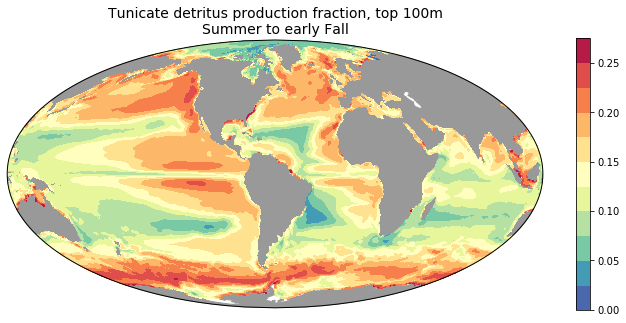

In [46]:
plt.figure(figsize=(12,5))
ax=plt.axes(projection=ccrs.Mollweide(central_longitude=300.0))

field=frac_tun_ndet_JJAS

ax.add_feature(cartopy.feature.LAND, zorder=0, facecolor='#999999')
cs=ax.contourf(grid.geolon.values, grid.geolat.values, field, transform=ccrs.PlateCarree(), levels=np.arange(0,0.3,0.025), cmap='Spectral_r')

plt.colorbar(cs, extend='both')
plt.title('Tunicate detritus production fraction, top 100m\nSummer to early Fall', fontsize=14)
plt.savefig('plots/'+fig_casename+'_'+pp_dates+'_Frac_tun_ndet_prod.png', dpi=300, bbox_inches='tight')

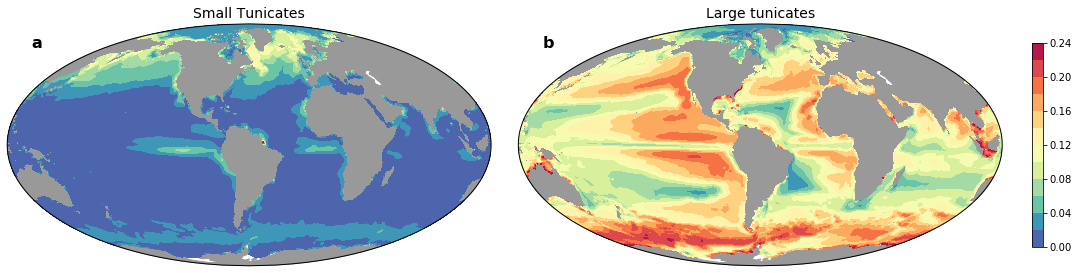

In [45]:
fig=plt.figure(figsize=(20,5))
gs=gridspec.GridSpec(1,2, wspace=0.05, width_ratios=[1,1.25])

ax={};cs={}

levels=np.arange(0,0.25,0.02)

# HP ingestion
i=0
field=frac_smt_ndet_JJAS
ax[i] = plt.subplot(gs[0,0],projection=ccrs.Mollweide(central_longitude=300.0))
ax[i].add_feature(cartopy.feature.LAND, zorder=0, facecolor='#999999')
cs[i]=ax[i].contourf(grid.geolon.values, grid.geolat.values, field, transform=ccrs.PlateCarree(), levels=levels, cmap='Spectral_r')                     
ax[i].set_title('Small Tunicates', fontsize=14)

ax[i].text(0.05, 0.95, 'a', transform=ax[i].transAxes, fontsize=16, fontweight='bold', va='top')

i=1
field=frac_lgt_ndet_JJAS
ax[i] = plt.subplot(gs[0,1],projection=ccrs.Mollweide(central_longitude=300.0))
ax[i].add_feature(cartopy.feature.LAND, zorder=0, facecolor='#999999')
cs[i]=ax[i].contourf(grid.geolon.values, grid.geolat.values, field, transform=ccrs.PlateCarree(), levels=levels, cmap='Spectral_r')                     
ax[i].set_title('Large tunicates', fontsize=14)
ax[i].text(0.05, 0.95, 'b', transform=ax[i].transAxes, fontsize=16, fontweight='bold', va='top')

plt.colorbar(cs[i], shrink=0.75, extend='both')

plt.tight_layout()
plt.savefig('plots/'+fig_casename+'_'+pp_dates+'_Frac_smt_lgt_ndet_prod.png', dpi=300, bbox_inches='tight')